<a href="https://colab.research.google.com/github/bbrauser/bbrauser/blob/main/Sales_Descriptive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About This Notebook

This data was downloaded from Kaggle.com (https://www.kaggle.com/datasets/knightbearr/sales-product-data?resource=download). It is sales data from a fictional company during 2019. We will call this company Acme, Inc.

# Data Description

• Order ID - An Order ID is the number system that Amazon uses exclusively to keep track of orders. Each order receives its own Order ID that will not be duplicated. This number can be useful to the seller when attempting to find out certain details about an order such as shipment date or status.

• Product - The product that have been sold.

• Quantity Ordered - Ordered Quantity is the total item quantity ordered in the initial order (without any changes).

• Price Each - The price of each products.

• Order Date - This is the date the customer is requesting the order be shipped.

• Purchase Address - The address from which the order was purchased.

# Importing the necessary libraries



In [145]:
import pandas as pd
pd.options.display.float_format = '{:,.0f}'.format
import numpy as np
import os
import calendar
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
from prophet import Prophet
import logging
from collections import Counter
import seaborn as sns
from itertools import combinations
from collections import defaultdict
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from scipy.stats import norm, kstest
from scipy import stats

# Importing the Data

In [146]:
# Define the base directory path for easier reference
base_dir = '/content/drive/MyDrive/Portfolio/SalesAnalytics/Data'

# List all files in the Data directory that end with .csv
files = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith('.csv')]

# Sort the files to ensure the order is correct
files.sort()

# Read and concatenate in one step
# Use a generator expression to lazily evaluate dataframes and concatenate
# Filter out rows that are headers while reading each file
old_df = pd.concat((pd.read_csv(file).query("`Order ID` != 'Order ID'") for file in files), ignore_index=True)

# For columns that need explicit conversion:
old_df['Order Date'] = pd.to_datetime(old_df['Order Date'], format='%m/%d/%y %H:%M')
old_df['Price Each'] = old_df['Price Each'].astype(float)
old_df['Quantity Ordered'] = old_df['Quantity Ordered'].astype(int)
old_df['Order Amount'] = (old_df['Quantity Ordered'] * old_df['Price Each'])

old_df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Order Amount
0,176558,USB-C Charging Cable,2,12,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",24
1,176559,Bose SoundSport Headphones,1,100,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",100
2,176560,Google Phone,1,600,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600
3,176560,Wired Headphones,1,12,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",12
4,176561,Wired Headphones,1,12,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",12
...,...,...,...,...,...,...,...
619261,156419,27in 4K Gaming Monitor,1,390,2019-02-18 13:31:00,"827 8th St, New York City, NY 10001",390
619262,156420,Macbook Pro Laptop,1,"1,700",2019-02-16 09:24:00,"488 Lake St, San Francisco, CA 94016","1,700"
619263,156421,AAA Batteries (4-pack),1,3,2019-02-18 22:01:00,"174 8th St, Atlanta, GA 30301",3
619264,156422,iPhone,1,700,2019-02-02 14:28:00,"746 South St, Austin, TX 73301",700


# Cleaning the Data

In [147]:
# Remove all NaN values from the dataset
old_df.dropna(inplace=True)

# Use convert_dtypes for an automatic conversion (it may not convert 'Order Date', so we'll still convert it manually)
df = old_df.convert_dtypes()

# Grouping rows by Order ID and combining products into a list
df = df.groupby('Order ID').agg({
    'Product': list,
    'Order Amount': 'sum',
    'Order Date': 'first',  # just taking the first date for demonstration
    'Purchase Address': 'first'  # same for address
}).reset_index()

In [148]:
# Function to convert the list of products into the desired format
def convert_product_list(product_list):
    counts = Counter(product_list)
    return ', '.join([f"{v}x {k}" for k, v in counts.items()])

# Apply the function to the 'Product' column
df['All Products'] = df['Product'].apply(convert_product_list)

# Central Tendency and Spread

## What was the mean order amount?

In [201]:
print(f"The mean order amount for 2019 was ${round(df['Order Amount'].mean(), 2)}.")

The mean order amount for 2019 was $321.91.


## What was the median order amount?

In [151]:
print(f"The median order amount for 2019 was ${np.median(df['Order Amount'])}.")

The median order amount for 2019 was $35.97.


## What were the top 3 most purchased products?

In [152]:
# Expand the 'Product' column to a long list of all products ordered
all_products = []
for product_string in df['All Products']:
    # Split by comma, then extract product name from strings like "2x iPhone"
    products = [item.split('x ')[1].strip() for item in product_string.split(', ')]
    all_products.extend(products)

# Count each product's frequency
product_counts = Counter(all_products)

# Determine the top 3 products
top_3_products = product_counts.most_common(3)

print(f"The top 3 products were {top_3_products[0][0]} with {format(top_3_products[0][1], ',')} units sold, "
      f"{top_3_products[1][0]} with {format(top_3_products[1][1], ',')} units sold, and "
      f"{top_3_products[2][0]} with {format(top_3_products[2][1], ',')} units sold")

The top 3 products were USB-C Charging Cable with 43,710 units sold, Lightning Charging Cable with 43,208 units sold, and AAA Batteries (4-pack) with 41,186 units sold


## What is the standard deviation for the order amount?

In [153]:
print(f"The standard deviation for the order amount is ${round(df['Order Amount'].std(),2)}")

The standard deviation for the order amount is $638.65


# Frequency and Distribution

## How many unique products are sold?

In [154]:
# Flatten the lists into individual rows
all_products = df['Product'].explode()

# Create a DataFrame of unique products
unique_products_df = pd.DataFrame(all_products.unique(), columns=['Unique Products'])

unique_products_df

,Unique Products
0,iPhone
1,Lightning Charging Cable
2,Wired Headphones
3,27in FHD Monitor
4,AAA Batteries (4-pack)
5,27in 4K Gaming Monitor
6,USB-C Charging Cable
7,Bose SoundSport Headphones
8,Apple Airpods Headphones
9,Macbook Pro Laptop


## How many orders were made per product?

In [155]:
# Explode the lists in the 'Product' column into individual rows
exploded_df = df.explode('Product')

# Now, group by 'Product' and count the number of orders
orders_per_product = exploded_df.groupby('Product').size().reset_index(name='Number of Orders')

# Formatting 'Number of Orders' column with commas
orders_per_product['Number of Orders'] = orders_per_product['Number of Orders'].apply(lambda x: "{:,}".format(x))

# Reset the index and drop the old one
orders_per_product.reset_index(drop=True, inplace=True)

# Print the DataFrame without index
print(orders_per_product.to_string(index=False))

                   Product Number of Orders
              20in Monitor           13,639
    27in 4K Gaming Monitor           20,764
          27in FHD Monitor           24,933
    34in Ultrawide Monitor           20,640
     AA Batteries (4-pack)           68,554
    AAA Batteries (4-pack)           68,780
  Apple Airpods Headphones           51,742
Bose SoundSport Headphones           44,358
             Flatscreen TV           16,011
              Google Phone           18,419
                  LG Dryer            2,166
        LG Washing Machine            2,201
  Lightning Charging Cable           72,125
        Macbook Pro Laptop           15,714
           ThinkPad Laptop           13,743
      USB-C Charging Cable           72,887
           Vareebadd Phone            6,905
          Wired Headphones           62,882
                    iPhone           22,803


## What is the distribution of order amounts?

### Filter outliers

In [202]:
# Calculate Q1, Q3 and IQR
Q1 = df['Order Amount'].quantile(0.25)
Q3 = df['Order Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
amount_outliers = df[(df['Order Amount'] >= lower_bound) & (df['Order Amount'] <= upper_bound)]

### Histogram

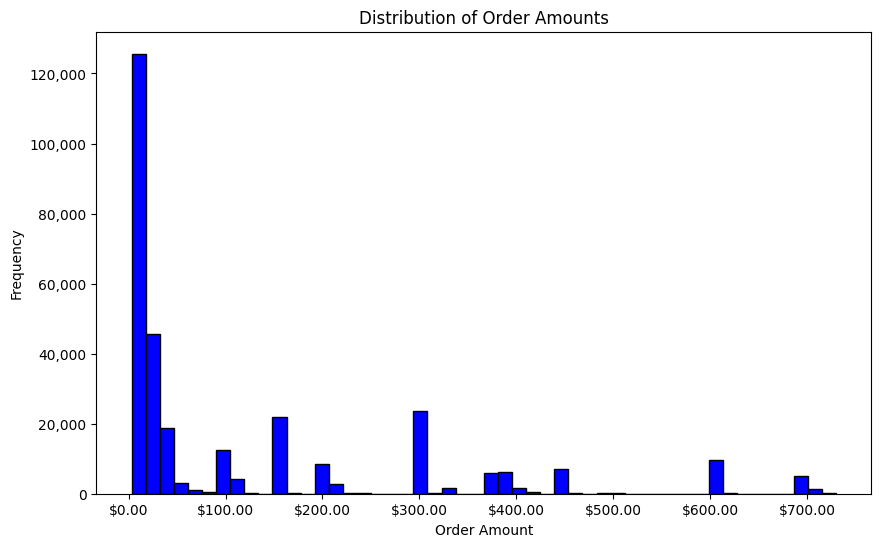

In [157]:
# Functions to format the x and y axes
def currency_formatter(x, _):
    return "${:,.2f}".format(x)

def comma_formatter(x, _):
    return "{:,.0f}".format(x)

# Plot
plt.figure(figsize=(10,6))
plt.hist(amount_outliers['Order Amount'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Order Amounts')

# Use the currency_formatter for the x-axis and comma_formatter for the y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))

plt.xlabel('Order Amount')
plt.ylabel('Frequency')
plt.show()

### Box Plot

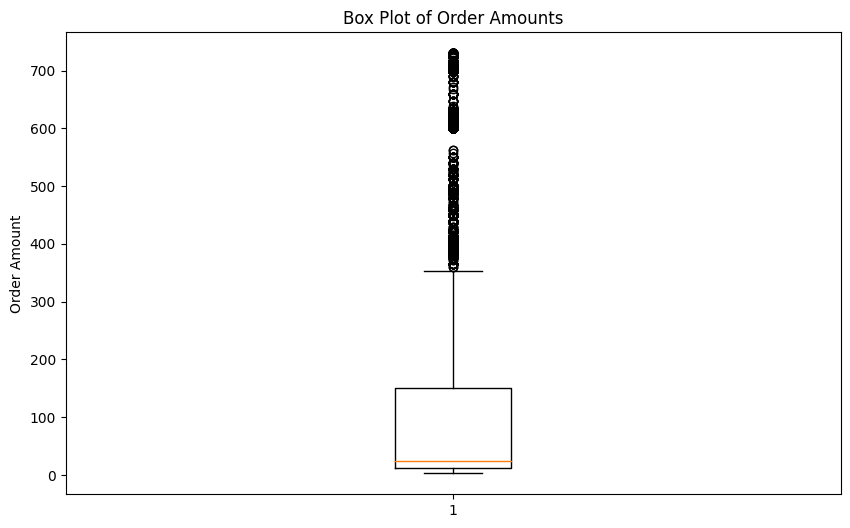

In [158]:
plt.figure(figsize=(10,6))
plt.boxplot(amount_outliers['Order Amount'])
plt.title('Box Plot of Order Amounts')
plt.ylabel('Order Amount')
plt.show()

### Density Plot

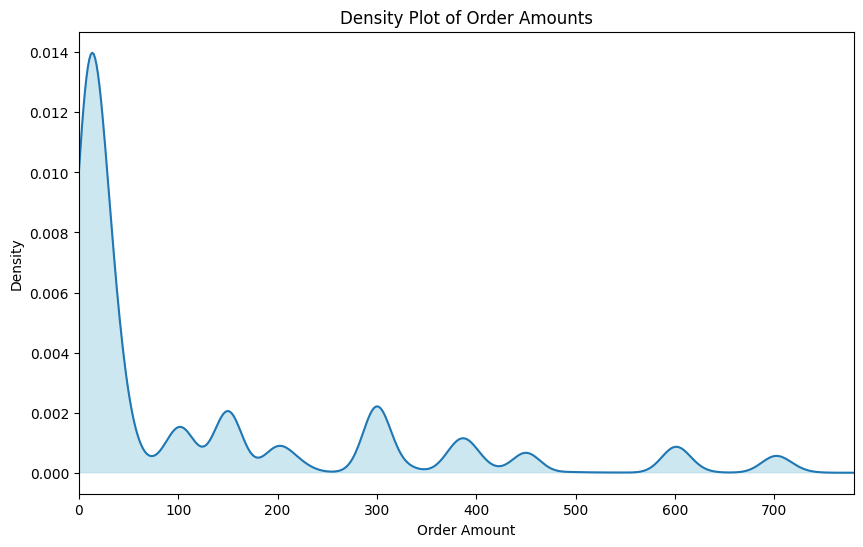

In [159]:
# Generate the density plot
ax = amount_outliers['Order Amount'].plot(kind='density', figsize=(10,6))
plt.title('Density Plot of Order Amounts')
plt.xlabel('Order Amount')
plt.xlim(0, amount_outliers['Order Amount'].max() + 50)  # Starting at 0 and giving some space after the maximum value

# Extract x and y data from the density plot
x, y = ax.get_lines()[0].get_data()

# Fill the area under the density curve
plt.fill_between(x, y, where=(x > 0), color='lightblue', alpha=0.6)

plt.show()

### Quantiles

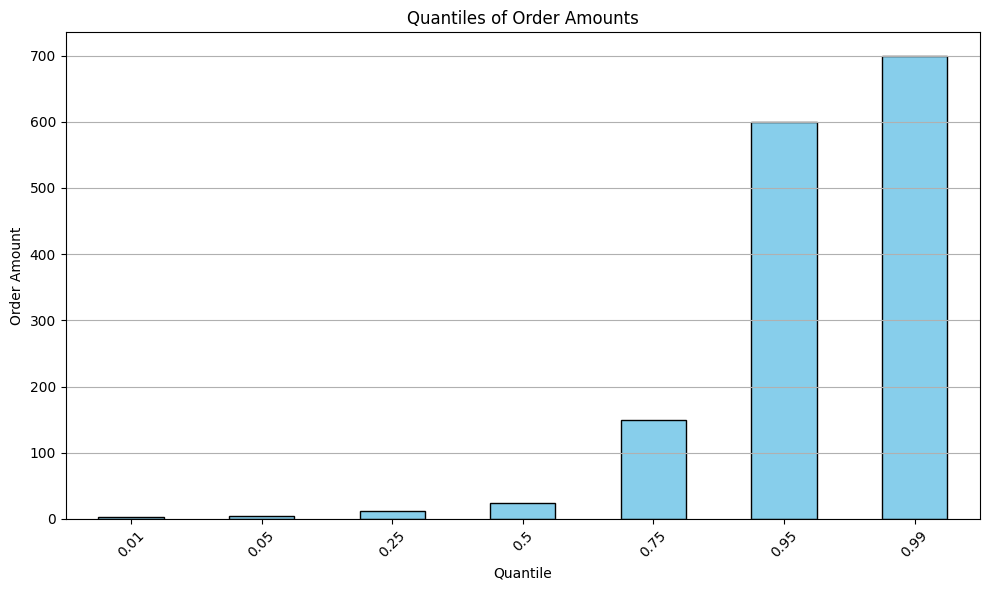

In [160]:
quantiles = amount_outliers['Order Amount'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

# Plotting
plt.figure(figsize=(10,6))
quantiles.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Quantiles of Order Amounts')
plt.ylabel('Order Amount')
plt.xlabel('Quantile')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time Series Analysis

## How many order were made per month?

In [161]:
# Extract the month from the 'Order Date' column
df['Month'] = df['Order Date'].dt.month

# Group by the extracted month and count unique orders
monthly_orders = df.groupby('Month')['Order ID'].nunique().reset_index()

# Substitute the month numbers for month names
monthly_orders['Month'] = monthly_orders['Month'].apply(lambda x: calendar.month_name[x])

# Format the 'Order ID' column with commas
monthly_orders['Order ID'] = monthly_orders['Order ID'].apply(lambda x: "{:,}".format(x))

# Rename columns
monthly_orders.columns = ['Month', 'Number of Orders']

# Print the result
monthly_orders

,Month,Number of Orders
0,January,"18,586"
1,February,"22,992"
2,March,"29,098"
3,April,"35,056"
4,May,"31,672"
5,June,"25,978"
6,July,"27,522"
7,August,"22,968"
8,September,"22,404"
9,October,"38,872"


## Which month had the highest sales, and which one had the lowest?

In [162]:
# Group by month and sum the 'Order Amount'
monthly_sales = df.groupby('Month').sum(numeric_only = True)['Order Amount']

# Determine the month with the highest and lowest sales
highest_sales_month = monthly_sales.idxmax()
lowest_sales_month = monthly_sales.idxmin()

# Extract the sales values for the highest and lowest months
highest_sales_value = monthly_sales[highest_sales_month]
lowest_sales_value = monthly_sales[lowest_sales_month]

# Print the results
print(f"The month with the highest sales is: {highest_sales_month} with a total order amount of ${highest_sales_value:,.2f}")
print(f"The month with the lowest sales is: {lowest_sales_month} with a total order amount of ${lowest_sales_value:,.2f}")

The month with the highest sales is: 12 with a total order amount of $18,450,956.85
The month with the lowest sales is: 1 with a total order amount of $5,475,440.48


## Are there any noticeable trends or patterns in sales over time?


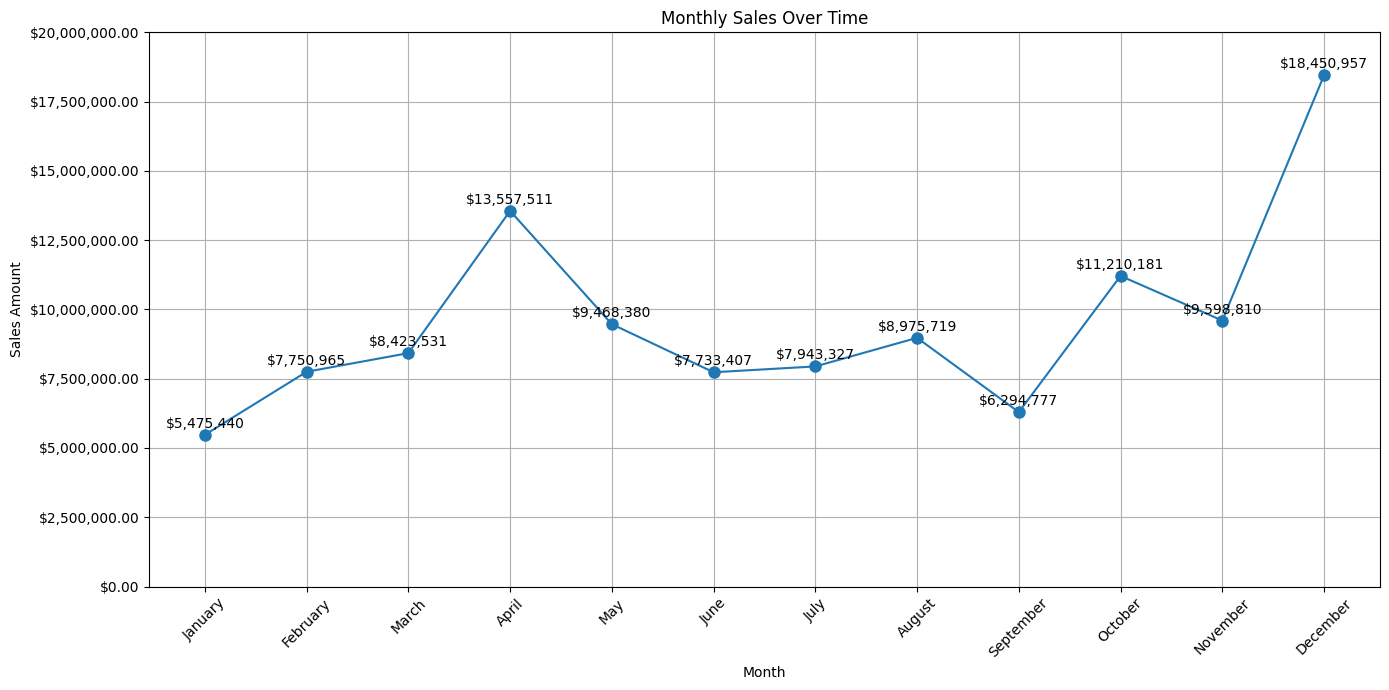

In [163]:
# Convert month numbers to month names
monthly_sales.index = [calendar.month_name[int(month)] for month in monthly_sales.index]

# Plotting the data
fig, ax = plt.subplots(figsize=(14, 7))

# Use the formatter for the y-axis
formatter = FuncFormatter(currency_formatter)
ax.yaxis.set_major_formatter(formatter)

# Plot data with larger markers
monthly_sales.plot(ax=ax, marker='o', markersize=8, linestyle='-')

# Annotating the plot with the monthly totals
for x, y in enumerate(monthly_sales):
    label = f"${y:,.0f}"  # Format y value as currency
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(0,5), ha='center')

# Setting y-axis ticks to have intervals of $5,000,000
max_y = monthly_sales.max()
ax.set_yticks(np.arange(0, max_y + 2500000, 2500000))

plt.title('Monthly Sales Over Time')
plt.ylabel('Sales Amount')
plt.xlabel('Month')

# Setting month names as x-ticks
ax.set_xticks(range(len(monthly_sales)))
ax.set_xticklabels(monthly_sales.index, rotation=45)

plt.grid(True)
plt.tight_layout()  # Adjust layout for better display
plt.show()

# Associative Analysis

## Is there a relationship between certain products?

In [164]:
# Filter rows where the 'Product' list has unique items and more than one item
df_filtered = df[df['Product'].apply(lambda x: len(set(x)) > 1)]

# Create all possible 2-product pairs from these lists
pairs = []

for products in df_filtered['Product']:
    for comb in combinations(products, 2):
        # Check if the two products in the pair are different
        if comb[0] != comb[1]:
            pairs.append(comb)

# Count the pairs
pair_count = Counter(pairs)

# Prepare the top 10 pairs for DataFrame display
top_pairs = [{"Product Pair": f"{pair[0]}, {pair[1]}", "Total Occurrences": freq} for pair, freq in pair_count.most_common(10)]

# Create a DataFrame to display the results
result_df = pd.DataFrame(top_pairs)

result_df

,Product Pair,Total Occurrences
0,"iPhone, Lightning Charging Cable",4977
1,"Google Phone, USB-C Charging Cable",4934
2,"iPhone, Wired Headphones",2260
3,"Google Phone, Wired Headphones",2088
4,"iPhone, Apple Airpods Headphones",1836
5,"Vareebadd Phone, USB-C Charging Cable",1822
6,"USB-C Charging Cable, Google Phone",1691
7,"Lightning Charging Cable, iPhone",1683
8,"Google Phone, Bose SoundSport Headphones",1113
9,"USB-C Charging Cable, Wired Headphones",871


## Are there any correlations between the price of a product and its sales frequency?

The correlation coefficient is -0.6, which indicates a strong, negative correlation.


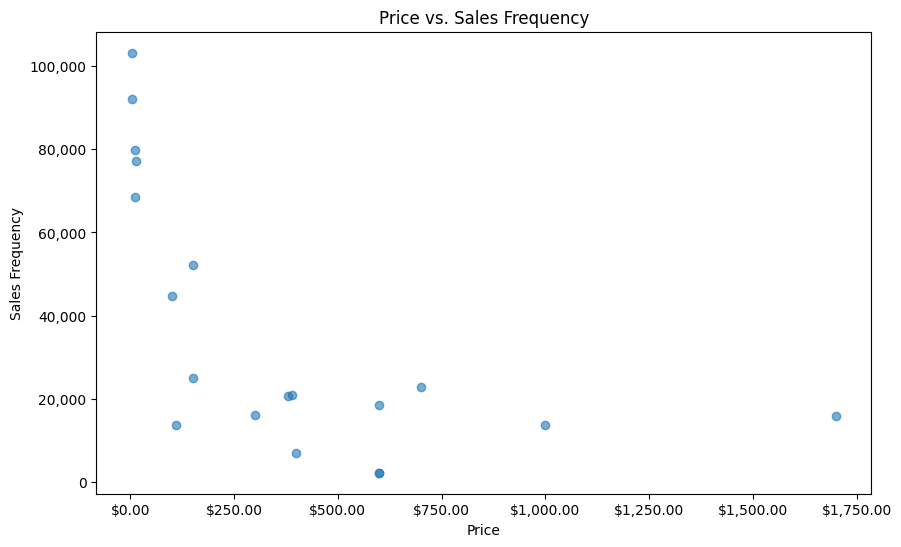

In [165]:
# Assuming old_df is already defined and populated
product_stats = old_df.groupby('Product').agg(
    {'Order Amount': 'sum',       # Total revenue
     'Quantity Ordered': 'sum',  # Total number of units sold
     'Price Each': 'mean'        # Average price, should be consistent for the same product
    }).reset_index()

def describe_correlation(r):
    direction = ''
    strength = ''

    # Determine direction
    if r < 0:
        direction = 'negative'
    elif r > 0:
        direction = 'positive'
    else:
        return 'neutral'  # If r is exactly 0

    # Determine strength
    abs_r = abs(r)
    if abs_r >= 0.8:
        strength = 'very strong'
    elif abs_r >= 0.6:
        strength = 'strong'
    elif abs_r >= 0.4:
        strength = 'moderate'
    elif abs_r >= 0.2:
        strength = 'weak'
    else:
        strength = 'very weak'

    return f"{strength}, {direction}"

correlation = product_stats['Price Each'].corr(product_stats['Quantity Ordered'])
print(f"The correlation coefficient is {round(correlation, 2)}, which indicates a {describe_correlation(correlation)} correlation.")

plt.figure(figsize=(10, 6))
plt.scatter(product_stats['Price Each'], product_stats['Quantity Ordered'], alpha=0.6)
plt.title('Price vs. Sales Frequency')
plt.xlabel('Price')
plt.ylabel('Sales Frequency')

# Apply the formatter to both x and y axes
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(comma_formatter))

plt.show()

# Location-Based Analysis

## Which cities or addresses have the highest number of orders?

In [166]:
# Function to format numbers with commas
def comma_format(n):
    return "{:,}".format(n)

# Extracting city and state from the 'Purchase Address'
df['City'] = df['Purchase Address'].apply(lambda x: f"{x.split(',')[1].strip()}, {x.split(',')[2].split()[0]}")

# Counting number of orders per city
city_order_counts = df.groupby('City').size().reset_index(name='Number of Orders')

# Apply the comma_format function to the 'Number of Orders' column
city_order_counts['Number of Orders'] = city_order_counts['Number of Orders'].apply(comma_format)

# Sorting by number of orders in descending order
city_order_counts = city_order_counts.sort_values(by='Number of Orders', ascending=False)

# Display the sorted DataFrame
print(city_order_counts)

                City Number of Orders
8  San Francisco, CA           85,796
4    Los Angeles, CA           56,996
5  New York City, NY           47,696
6       Portland, ME            4,726
2         Boston, MA           38,184
0        Atlanta, GA           28,506
3         Dallas, TX           28,480
9        Seattle, WA           28,238
7       Portland, OR           19,234
1         Austin, TX           19,018


## What is the mean order amount per city?

In [167]:
# Extracting city from Purchase Address
df['City'] = df['Purchase Address'].str.extract(r',\s*([^,]+),\s*[A-Z]{2}\s*\d{5}')

# Group by city and compute average order amount
avg_order_per_city = df.groupby('City')['Order Amount'].mean().reset_index()

# Sorting the result for better visualization (optional)
avg_order_per_city['Order Amount'] = avg_order_per_city['Order Amount'].apply(lambda x: "${:,.2f}".format(x))

avg_order_per_city

,City,Order Amount
0,Atlanta,$326.12
1,Austin,$318.07
2,Boston,$319.57
3,Dallas,$323.64
4,Los Angeles,$317.84
5,New York City,$326.01
6,Portland,$322.85
7,San Francisco,$320.87
8,Seattle,$325.38


## What is the median order amount per city?

In [168]:
median_order_per_city = df.groupby('City')['Order Amount'].median().reset_index()

# Format the amounts in currency format
median_order_per_city['Order Amount'] = median_order_per_city['Order Amount'].apply(lambda x: f"${x:.2f}")

median_order_per_city

,City,Order Amount
0,Atlanta,$35.97
1,Austin,$35.97
2,Boston,$35.85
3,Dallas,$35.97
4,Los Angeles,$35.85
5,New York City,$35.97
6,Portland,$35.97
7,San Francisco,$35.97
8,Seattle,$35.97


## Outliers and Anomalies

### Are there any unusally high or low order amounts that could be considered outliers?

In [169]:
# Calculate Q1 and Q3
Q1 = df['Order Amount'].quantile(0.25)
Q3 = df['Order Amount'].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter dataframe for outliers
outliers = df[(df['Order Amount'] < lower_bound) | (df['Order Amount'] > upper_bound)]

outliers

,Order ID,Product,Order Amount,Order Date,Purchase Address,All Products,Month,City
0,141234,"[iPhone, iPhone]","1,400",2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",2x iPhone,1,Boston
6,141240,"[27in 4K Gaming Monitor, 27in 4K Gaming Monitor]",780,2019-01-26 12:16:00,"979 Park St, Los Angeles, CA 90001",2x 27in 4K Gaming Monitor,1,Los Angeles
11,141245,"[Macbook Pro Laptop, Macbook Pro Laptop]","3,400",2019-01-31 10:12:00,"322 6th St, San Francisco, CA 94016",2x Macbook Pro Laptop,1,San Francisco
16,141250,"[Vareebadd Phone, Vareebadd Phone]",800,2019-01-10 11:20:00,"471 Center St, Los Angeles, CA 90001",2x Vareebadd Phone,1,Los Angeles
22,141256,"[Google Phone, Google Phone]","1,200",2019-01-29 10:40:00,"675 Washington St, Portland, OR 97035",2x Google Phone,1,Portland
...,...,...,...,...,...,...,...,...
356810,319607,[Macbook Pro Laptop],"1,700",2019-12-25 20:07:00,"620 Church St, Atlanta, GA 30301",1x Macbook Pro Laptop,12,Atlanta
356825,319622,[Macbook Pro Laptop],"1,700",2019-12-15 07:11:00,"180 Ridge St, Boston, MA 02215",1x Macbook Pro Laptop,12,Boston
356842,319639,[Macbook Pro Laptop],"1,700",2019-12-20 10:56:00,"616 Highland St, Seattle, WA 98101",1x Macbook Pro Laptop,12,Seattle
356844,319641,[Macbook Pro Laptop],"1,700",2019-12-04 23:11:00,"232 Meadow St, Portland, OR 97035",1x Macbook Pro Laptop,12,Portland


## Are there any specific days with extraordinarily high or low sales?

In [170]:
# Aggregate sales by day
daily_sales = df.groupby(df['Order Date'].dt.date)['Order Amount'].sum()

# Calculate statistical metrics
mean_sales = daily_sales.mean()
std_sales = daily_sales.std()

# Identify outliers
high_outliers = daily_sales[daily_sales > mean_sales + 2 * std_sales]
low_outliers = daily_sales[daily_sales < mean_sales - 2 * std_sales]

# Format the values in dollar format
high_outliers_formatted = high_outliers.map('${:,.2f}'.format)
low_outliers_formatted = low_outliers.map('${:,.2f}'.format)

# Format the index (date) in the desired format
high_outliers_formatted.index = pd.to_datetime(high_outliers_formatted.index).strftime('%B %d, %Y')
low_outliers_formatted.index = pd.to_datetime(low_outliers_formatted.index).strftime('%B %d, %Y')

print("Days with outlying high sales:")
print(high_outliers_formatted)

print("\nDays with outlying low sales:")
print(low_outliers_formatted)

Days with outlying high sales:
Order Date
April 24, 2019       $544,709.28
December 01, 2019    $589,798.01
December 02, 2019    $596,102.84
December 03, 2019    $570,281.80
December 04, 2019    $666,910.76
December 05, 2019    $620,317.20
December 06, 2019    $607,641.88
December 07, 2019    $558,583.00
December 08, 2019    $574,110.52
December 09, 2019    $588,540.52
December 10, 2019    $651,330.96
December 11, 2019    $585,468.12
December 12, 2019    $576,780.60
December 13, 2019    $613,328.56
December 14, 2019    $567,967.12
December 15, 2019    $573,078.88
December 16, 2019    $651,882.44
December 17, 2019    $629,458.88
December 18, 2019    $618,395.08
December 19, 2019    $550,930.68
December 20, 2019    $640,725.20
December 21, 2019    $619,027.48
December 22, 2019    $589,392.36
December 23, 2019    $608,857.80
December 24, 2019    $611,555.28
December 25, 2019    $609,073.68
December 26, 2019    $579,648.08
December 29, 2019    $624,098.48
December 30, 2019    $609,279.24
N

## Which products have the highest revenue contribution?

In [171]:
old_df['Product'] = old_df['Product'].astype(str)

# Group by 'Product' and sum the 'Order Amount' for each product
product_revenues = old_df.groupby('Product')['Order Amount'].sum().reset_index()

# Sort the products by revenue in descending order
sorted_products = product_revenues.sort_values('Order Amount', ascending=False)
sorted_products['Order Amount'] = sorted_products['Order Amount'].apply(lambda x: "${:,.2f}".format(x))

sorted_products

,Product,Order Amount
13,Macbook Pro Laptop,"$26,737,600.00"
18,iPhone,"$15,978,200.00"
14,ThinkPad Laptop,"$13,748,862.51"
9,Google Phone,"$11,067,000.00"
1,27in 4K Gaming Monitor,"$8,116,081.89"
3,34in Ultrawide Monitor,"$7,866,172.99"
6,Apple Airpods Headphones,"$7,817,700.00"
8,Flatscreen TV,"$4,821,900.00"
7,Bose SoundSport Headphones,"$4,478,852.07"
2,27in FHD Monitor,"$3,761,149.24"


## What are the top 5 products have the highest number of orders contributre the lowest to the overall revenue?

In [172]:
# Group by the 'Product' column and aggregate the sum of 'Quantity Ordered' and 'Order Amount'
product_sales = old_df.groupby('Product').agg({
    'Quantity Ordered': 'sum',
    'Order Amount': 'sum'
}).reset_index()

# Calculate total revenue
total_revenue = product_sales['Order Amount'].sum()

# Compute the percentage of total revenue for each product
product_sales['Percentage of Total Revenue'] = (product_sales['Order Amount'] / total_revenue) * 100

# Sort by 'Quantity Ordered' to see products that are sold often
product_sales = product_sales.sort_values(by='Quantity Ordered', ascending=False)

# Format the 'Order Amount' and 'Percentage of Total Revenue' columns for better readability
product_sales['Order Amount'] = product_sales['Order Amount'].apply(lambda x: f"${x:,.2f}")
product_sales['Percentage of Total Revenue'] = product_sales['Percentage of Total Revenue'].apply(lambda x: f"{x:.2f}%")

product_sales.head(5)

,Product,Quantity Ordered,Order Amount,Percentage of Total Revenue
5,AAA Batteries (4-pack),103249,"$308,714.51",0.27%
4,AA Batteries (4-pack),92211,"$354,090.24",0.31%
15,USB-C Charging Cable,79758,"$953,108.10",0.83%
12,Lightning Charging Cable,77306,"$1,155,724.70",1.01%
17,Wired Headphones,68435,"$820,535.65",0.71%


# Seasonal Analysis

## Are there specific products that see a spike in orders during certain seasons or months?

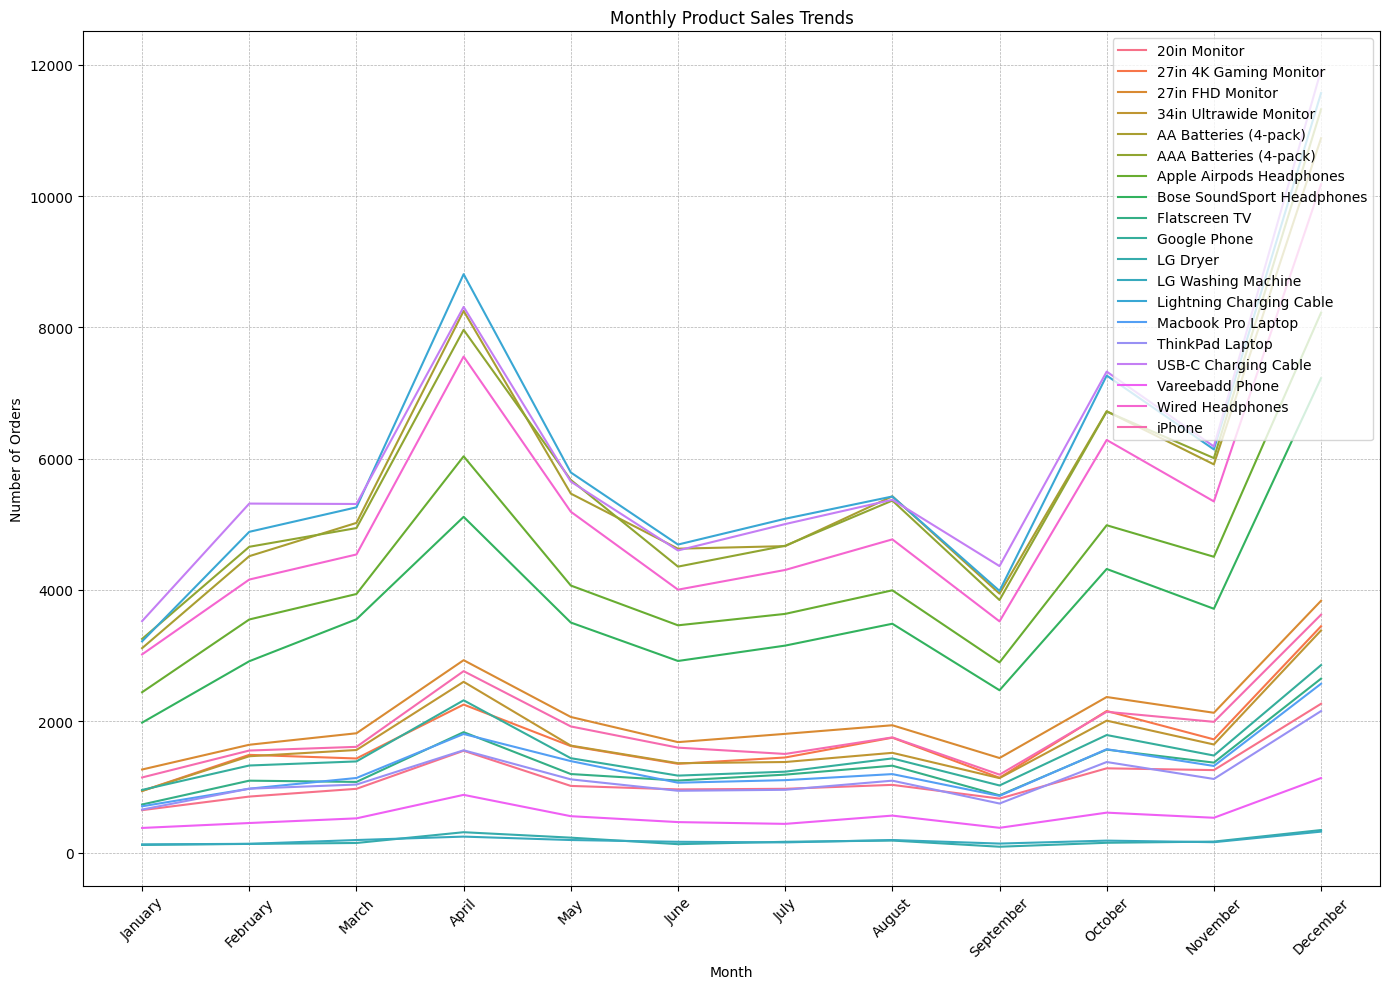

In [173]:
old_df['Month'] = old_df['Order Date'].dt.month

grouped = old_df.groupby(['Month', 'Product']).size().reset_index(name='Order Count')

grouped['Month'] = grouped['Month'].apply(lambda x: calendar.month_name[x])

plt.figure(figsize=(14, 10))
sns.lineplot(data=grouped, x='Month', y='Order Count', hue='Product')
plt.title("Monthly Product Sales Trends")
plt.ylabel("Number of Orders")
plt.xlabel("Month")
plt.legend(loc='upper right')
plt.xticks(rotation=45)  # This will make month names more readable by rotating them
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # This ensures that everything fits properly
plt.show()

## Are there any noticeable sales patterns around holidays?

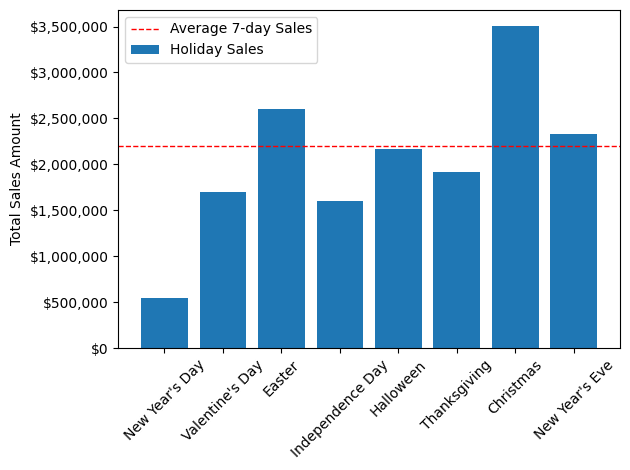

In [174]:
# List of holidays and their dates
holidays = {
    "New Year's Day": '2019-01-01',
    "Valentine's Day": '2019-02-14',
    "Easter": '2019-04-21',
    "Independence Day": '2019-07-04',
    "Halloween": '2019-10-31',
    "Thanksgiving": '2019-11-28',
    "Christmas": '2019-12-25',
    "New Year's Eve": '2019-12-31'
}

# Function to aggregate sales for a specific period
def get_sales_for_period(df, start_date, end_date):
    mask = (df['Order Date'] >= start_date) & (df['Order Date'] <= end_date)
    return df[mask]['Order Amount'].sum()

# Get the total sales for each holiday
holiday_sales = {}
for holiday, date in holidays.items():
    start_date = pd.to_datetime(date) - pd.Timedelta(days=3)
    end_date = pd.to_datetime(date) + pd.Timedelta(days=3)
    holiday_sales[holiday] = get_sales_for_period(df, start_date, end_date)

# Get average daily sales as a baseline
avg_daily_sales = df['Order Amount'].sum() / (df['Order Date'].max() - df['Order Date'].min()).days

# Function to format as dollars
def currency(x, pos):
    """The two args are the value and tick position."""
    return '${:,.0f}'.format(x)

# Plotting
fig, ax = plt.subplots()
ax.bar(holiday_sales.keys(), holiday_sales.values(), label='Holiday Sales')
ax.axhline(avg_daily_sales * 7, color='r', linestyle='dashed', linewidth=1, label='Average 7-day Sales')  # Multiply by 7 for a week's worth of sales
plt.xticks(rotation=45)
plt.ylabel('Total Sales Amount')

# Set the formatter
formatter = ticker.FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

plt.legend()
plt.tight_layout()
plt.show()

# Price Point Analysis

## How many products are sold above the average price point? How many below?


In [198]:
# Calculate the average price point
average_price = old_df['Price Each'].mean()

# Filter the unique products and their prices
unique_products = old_df.drop_duplicates(subset='Product')[['Product', 'Price Each']]

# Calculate the percentage difference for each product relative to the average price point
unique_products['Price Difference (%)'] = ((unique_products['Price Each'] - average_price) / average_price) * 100

# Sort the dataframe by Price Difference in ascending order
unique_products = unique_products.sort_values(by="Price Difference (%)", ascending=True)

# Format the Price Each and percentage columns
unique_products['Price Each'] = unique_products['Price Each'].apply(lambda x: f"${x:.2f}")
unique_products['Price Difference (%)'] = unique_products['Price Difference (%)'].apply(lambda x: f"{x:.2f}%")

# Display the dataframe
unique_products

,Product,Price Each,Price Difference (%)
19,AAA Batteries (4-pack),$2.99,-98.38%
13,AA Batteries (4-pack),$3.84,-97.92%
0,USB-C Charging Cable,$11.95,-93.52%
3,Wired Headphones,$11.99,-93.50%
11,Lightning Charging Cable,$14.95,-91.89%
1,Bose SoundSport Headphones,$99.99,-45.78%
34,20in Monitor,$109.99,-40.36%
33,27in FHD Monitor,$149.99,-18.67%
15,Apple Airpods Headphones,$150.00,-18.66%
28,Flatscreen TV,$300.00,62.67%
